In [ ]:
%%HTML
<!-- Mejorar visualización en proyector -->
<style>
.rendered_html {font-size: 1.2em; line-height: 150%;}
div.prompt {min-width: 0ex; padding: 0px;}
.container {width:95% !important;}
</style>

In [ ]:
%autosave 0
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm_notebook
import corner

# A (brief) tutorial on [Pyro](https://pyro.ai/)

Pyro can be used to perform MCMC and/or approximate inference for intractable posteriors

We can use Pyro to move from point estimates to posteriors in our **torch-based model**

In [ ]:
import pyro
display(pyro.__version__)
pyro.set_rng_seed(101)

Let's start by creating a normal distribution

Distributions in Pyro are implemented in [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

The `Normal` object expects location $\mu$ and scale $\sigma$

In [ ]:
from pyro.distributions import Normal

w_prior = Normal(loc=torch.tensor(0.), 
                 scale=torch.tensor(1.))

We can sample from this distribution

In [ ]:
# Get 1000 samples 
samples = w_prior.rsample(sample_shape=(1000, ))
display(samples.shape)
# Build an histogram
fig, ax = plt.subplots(figsize=(7, 3))
plt.hist(samples.detach().numpy(), bins=20, density=True)
# Plot the pdf
w_plot = np.linspace(-3, 3, num=100)
w_pdf = torch.exp(w_prior.log_prob(torch.from_numpy(w_plot))).detach().numpy()
plt.plot(w_plot, w_pdf, 'k-', lw=2);

We can compute descriptors

In [ ]:
#mean
display(w_prior.mean)
#standard deviation
display(w_prior.stddev)
#entropy
display(w_prior.entropy())

#### Shape of pyro tensors

A distribution has two shapes

`event_shape` refers to the dimensionality of the distribution, e.g. normal (number), multivariate normal (vector), Cholesky (matrix), etc

> `event_shape` denotes dependent random variables

`batch_shape` refers to a batch of distributions

> `batch_shape` denotes conditionally independent random variables (typically our data dimension)

We can create a batched distribution by batching the parameters

The shape of a sampled tensor will be the sum of event and batch shapes

In [ ]:
# Two conditionally independent normal RVs
w_prior = Normal(torch.tensor([[0., 2.]]), torch.tensor([[1., 1.]]))
# A multivariate normal with diagonal covariance
#w_prior = Normal(torch.tensor([[0., 2.]]), torch.tensor([[1., 1.]])).to_event(1)

display(w_prior.batch_shape)
display(w_prior.event_shape)
display(w_prior.rsample().shape)

## Random variables in Pyro

To create random variables that we can track within a model we use [`pyro.sample`](http://pyro.ai/examples/intro_part_i.html#The-pyro.sample-Primitive)

`sample` expects a name and an object from [`pyro.distributions`](http://docs.pyro.ai/en/stable/distributions.html)

For example, to create a variable named "w" with the previously defined distribution
$$
\begin{align}
w \sim &\mathcal{N}(\mu, \sigma^2) \nonumber \\
&\mu = \begin{pmatrix}0 \\ 2 \end{pmatrix}, \sigma = \begin{pmatrix} 1 \\ 1 \end{pmatrix} \nonumber
\end{align}
$$

In [ ]:
def model():
    return pyro.sample(name='w', 
                       fn=w_prior)

Each time we run a model a random sample is returned

In [ ]:
for i in range(10):
    print(model())

### Models and conditioning 

Let's consider a linear regression model

$$
y = w x + b
$$

We will write this model in Pyro 

For this we consider
- $w$ and $b$ to be random variables with normal distributions (priors)
- $y$ to be a random variable with normal distribution (likelihood)
- $x$ to be a deterministic variable
- $y$ is continioned to the observed data $\{y_i\}$


In [ ]:
def model(x):
    w = pyro.sample("w", Normal(0.0, 10.0))
    b = pyro.sample("b", Normal(0.0, 10.0))
    with pyro.plate('dataset', size=len(x)):
        return pyro.sample("y", Normal(x*w + b, 1.0))

def conditioned_model(x, y):
    return pyro.condition(model, data={"y": y})(x)

# or equivalently

def model_obs(x, y):  # equivalent to conditioned_scale above
    w = pyro.sample("w", Normal(0.0, 10.0))
    b = pyro.sample("b", Normal(0.0, 10.0))
    with pyro.plate('dataset', size=len(x)):
        return pyro.sample("y", Normal(x*w + b, 1.0), obs=y)

#### Technical details

To create conditions we can use `pyro.condition` or the `obs` keyword of `pyro.sample`

To create conditions on the whole dataset (assuming iid) we use [`pyro.plate`](http://docs.pyro.ai/en/stable/primitives.html#pyro.plate), which expects a name and the size of the dataset

In this case we use `pyro.plate` as a context (vectorized plate), it can also be used as an iterator


#### Theorical details

In summary the model has to define the generative process 

In this case
- Choose hyperparameters: $\mu_w, \sigma_w, \mu_b, \sigma_b, \sigma_\epsilon$
- Sample: $w \sim \mathcal{N}(\mu_w, \sigma_w^2)$
- Sample: $b \sim \mathcal{N}(\mu_b, \sigma_b^2)$
- For each $i=1,2,\ldots, N$
    - Sample: $y_i \sim \mathcal{N}(w x_i + b, \sigma_\epsilon^2)$

This is often summarized using plate notation diagrams

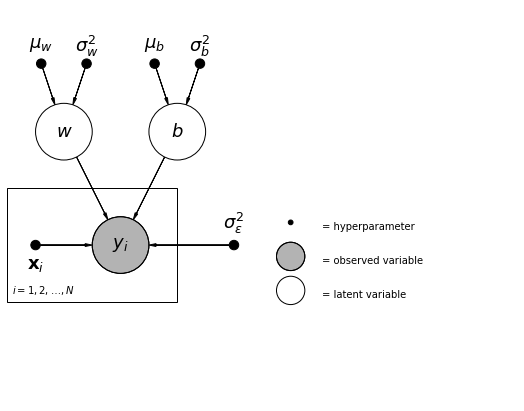

# Inference

Now that we have specified the model we would like to obtain the posterior of the parameters given the data and do predictions

> If we can not solve it analytically or via enumeration we can resort to approximate inference

Pyro offers different ways to perform approximate inference in the module [`pyro.infer`](https://docs.pyro.ai/en/stable/inference.html)

For now we will focus on **Stochastic Variational Inference** 


The unified Variational Inference interface in Pyro is located in [`pyro.infer.SVI`](http://docs.pyro.ai/en/stable/inference_algos.html) 

To use SVI we need to specify
1. A model function that defines our generative model
1. A guide function that defines our approximate posterior
1. A cost function 
1. An optimizer
1. Number of samples to compute Monte-Carlo estimates

### Guide function

> The guide represents our approximate posterior $q_\nu(\theta)$ 

The guide has to define the distribution of the posterior of the parameters 

We use [`pyro.param`]() to register the hyperparameters of the approximate posterior $\eta$

> These parameters are the ones that we learn through optimization

**Technical detail:** The guide function has the same inputs as the model function

In this example we set a normal posterior $\theta=(w, b)$ and create the corresponding hyperparameters $\eta = (\mu_w, \sigma_w, \mu_b, \sigma_b)$

In [ ]:
from torch.distributions import constraints

def guide(x, y):
    w_loc = pyro.param("w_loc", torch.tensor(0.))
    w_scale = pyro.param("w_scale", torch.tensor(1.), constraint=constraints.positive)
    w = pyro.sample("w", Normal(w_loc, w_scale))
    b_loc = pyro.param("b_loc", torch.tensor(0.))
    b_scale = pyro.param("b_scale", torch.tensor(1.), constraint=constraints.positive)
    b = pyro.sample("b", Normal(b_loc, b_scale))

### Cost function

In the previous class we studied the Evidence Lower Bound (ELBO)

$$
\begin{align}
\hat \nu &= \text{arg}\max_\nu \mathcal{L}(\nu) \nonumber \\
&= \text{arg}\max_\nu - \int q_\nu(\theta) \log \frac{q_\nu(\theta)}{p(\mathcal{D}|\theta) p (\theta)} d\theta
\end{align}
$$

where
- The model function defines $p(\mathcal{D}|\theta) p (\theta)$ 
- The guide function defines $q_\nu(\theta)$ 

Pyro offers several versions of the [ELBO](https://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.elbo)

- `Trace_ELBO`: Default ELBO. Reduces variance of the gradients using "Rao-Blackwellization"
- `TraceEnum_ELBO`: Performs exhaustive enumeration for discrete variables
- `TraceMeanField_ELBO`: Assumes Mean-field structure. Reduce variance of gradients using analytical KL when possible

> We will study the importance of gradient variance later

### Training

Once we have defined the model and guide we create an SVI object

In this example we select the default ELBO and SGD with adaptive learning rate optimizer

In [ ]:
pyro.enable_validation(True)
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model_obs, guide=guide,
                     loss=pyro.infer.Trace_ELBO(),
                     optim=pyro.optim.ClippedAdam({"lr": 0.01}))

The main method of SVI is 

- `svi.step(*args)`: Performs a gradient step, similar to `backward` plus `step` in pytorch

`step` receives the inputs for guide and model as arguments

In [ ]:
# Observed data
x = torch.tensor([-2., 2.])
y = torch.tensor([-2., 0.])

fig, ax = plt.subplots(1, 5, figsize=(8, 2), dpi=120, tight_layout=True)
lines = [ax_.plot([], [])[0] for ax_ in ax]
param_names = ["ELBO", "w_loc", "w_scale", "b_loc", "b_scale"]
param_evolution = {}
for name in param_names:
    param_evolution[name] = []
    
for ax_, name in zip(ax, param_names):
    ax_.set_title(name)
    
for k in tqdm_notebook(range(3000)):
    param_evolution["ELBO"].append(svi.step(x, y))
    for name in param_names[1:]:
        param_evolution[name].append(pyro.param(name).item()) 
    
    if np.mod(k, 100) == 0:
        for i, name in enumerate(param_names):
            lines[i].set_ydata(param_evolution[name][:k])
        for line in lines:
            line.set_xdata(range(k))
        for ax_ in ax.ravel():
            ax_.relim()
            ax_.autoscale_view()
        fig.canvas.draw()

We see that the ELBO and the parameters have converged

We can evaluate our results by observing the posteriors that we learnt

In [ ]:
w_plot = Normal(pyro.param('w_loc'), pyro.param('w_scale')).rsample((10000,)).detach().numpy()
b_plot = Normal(pyro.param('b_loc'), pyro.param('b_scale')).rsample((10000,)).detach().numpy()

figure = corner.corner(np.stack((b_plot, w_plot)).T, smooth=1.,
                       labels=["bias", "weight"], bins=20, 
                       quantiles=[0.16, 0.5, 0.84], range=[(-4, 4), (-4, 4)],
                       show_titles=True, title_kwargs={"fontsize": 12})

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)

line_x = np.linspace(-5, 5, num=100).astype('float32') 

for i in range(100):    
    line_y = line_x*w_plot[i] + b_plot[i]
    ax.plot(line_x, line_y, c='tab:blue', alpha=0.2)

ax.errorbar(2, 0, xerr=0, yerr=2, fmt='none', c='k', zorder=100);
ax.errorbar(-2, -2., xerr=0, yerr=2, fmt='none', c='k', zorder=100);

We can also plot the predictive posterior

For the moment the pyro interface to do this is a bit clunky

In [ ]:
from pyro.distributions import Delta
from pyro.infer import EmpiricalMarginal, TracePredictive

posterior = svi.run(x, y)

def wrapped_model(x, y):
    pyro.sample("prediction", Delta(model_obs(x, y)))

trace_predictive = TracePredictive(wrapped_model, posterior, num_samples=10000)
posterior_predictive = trace_predictive.run(torch.from_numpy(line_x), None)
posterior_trace = EmpiricalMarginal(posterior_predictive, "prediction").enumerate_support().detach().cpu().numpy()

med = np.median(posterior_trace, axis=0)
qua = np.quantile(posterior_trace, (0.05, 0.95), axis=0)

fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(line_x, med)
ax.fill_between(line_x, qua[0], qua[1], alpha=0.5);

### MCMC with Pyro

[On the MCMC side Pyro](https://docs.pyro.ai/en/stable/mcmc.html) offers Hamiltonian Monte-Carlo and the more recent No-U turn sampler (NUTS)

For theoretical details see Barber Chapter 27 or [here](https://github.com/magister-informatica-uach/INFO337/tree/master/MCMC)

Here we run MCMC as a reference

In [ ]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

nuts_kernel = NUTS(model_obs, adapt_step_size=True)
sampler = MCMC(nuts_kernel, num_chains=1, num_samples=10000, warmup_steps=1000)
sampler.run(x, y)

Print a summary:

In [ ]:
sampler.summary()

Plot the posteriors

In [ ]:
samples = sampler.get_samples()
w_plot = samples['w'].detach().numpy()
b_plot = samples['b'].detach().numpy()

figure = corner.corner(np.stack((b_plot, w_plot)).T, smooth=1.,
                       labels=["b", "w"], bins=20, 
                       quantiles=[0.16, 0.5, 0.84], range=[(-4, 4), (-4, 4)],
                       show_titles=True, title_kwargs={"fontsize": 12})

Not too different from the VI solution

But remember, in this case we used to actual posterior (normal) in the guide

Most of the time we won't be so lucky

# Pyro summary

- We create (deterministic) parameters with `pyro.param`
- We create latent random variables using `pyro.sample`
- We create observed random variables using `pyro.sample` with the `obs` keyword

> The model represents our graphical model

> The guide represents our assumptions on the latent variables

# Bayesian Neural Networks

> Deep Neural Networks are non-linear function approximators which represent the state of the art in pattern recognition

But they do have limitations

- Very deep models require lots of data and can be hard to train
- Selecting an architecture requires a lot of experimentation
- [Not too robust](https://openai.com/blog/adversarial-example-research/)
- Poor at representing uncertainty

> We can leverage some of these by going Bayesian

- A Bayesian neural network (BNN) places a prior distribution on its parameters 
- Training the BNN $\equiv$ Learning the posterior distribution of the parameters given the data
- The **uncertainty on the data and the parameters** can be propagated to estimate the **uncertainty on our predictions**
    - Uncertainty on the data is called **aleatoric uncertainty** and it is related to irreducible noise
    - Uncertainty on the model (parameters and structure) is called **epistemic uncertainty**

> We know what we don't know

We can use this "new knowledge" to
- Decide when to use a more simple/complex model (complexity-control)
- Decide when to take a critical decisions
    - Autonomouse cars
    - Cancer diagnosis

## A bit of history

> Bayesian neural networks is an active area of research 

- 1980's: Bayes theorem applied to Neural Networks (John Hopfield and Naftali Tishby)
- 1990's: Monte-Carlo and VI for bayesian neural networks was studied extensively by [David Mackay](http://www.inference.org.uk/mackay/BayesNets.html) and [Radford Neal](https://www.cs.toronto.edu/~radford/res-neural.html) (Also Bishop, Barber, Hinton, Gharamani and many others). Neal shows that Gaussian process are bayesian neural networks with infinite neurons

> The models remain quite difficult to train for some time

- 2010's: Deep learning arrives 
- 2011: [Alex Graves' VI for neural networks](https://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks)
- Explosion of practical deep bayesian networks 
    - [Charles Blundell's Bayes by backprop](https://arxiv.org/abs/1505.05424)
    - [Yarin Gal's many work](http://mlg.eng.cam.ac.uk/yarin/thesis/thesis.pdf)
    - Durk Kingma, Danilo Jimenez Rezende, Shakir Mohamed, José Miguel Hernandez-Lobato
- [Hot topic now a days](http://bayesiandeeplearning.org/)

History in video by [Zoubin Gharamani](http://mlg.eng.cam.ac.uk/zoubin/) at [NIPS 2016](https://www.youtube.com/watch?v=FD8l2vPU5FY) and [interesting panel discussion](https://www.youtube.com/watch?v=HumFmLu3CJ8) on the same conference


### More formally


Assuming we have *iid* samples $\mathcal{D} =\{(x^{(1)}, y^{(1)}), \ldots \}$ and a one-layer fully-connected neural networks for regression

$$
\begin{align}
f(x) &=   b_i + \sum_{j=1}^H w_{ij} h_j  \nonumber \\
&=  b_i + \sum_{j=1}^H w_{ij} g \left( b_j + \sum_{d=1}^D w_{jd} x_d  \right) \nonumber
\end{align}
$$

The parameter vector $\theta$ contains all the weights and biases

First we propose a prior for $\theta$, typically

$$
\theta \sim \mathcal{N}(\theta | 0, \Sigma_\theta)
$$

Then we propose a likelihood depending on our task (Gaussian for regression, Bernoulli for classification)

Finally we use Bayes theorem to write the posterior

$$
p(\theta | \mathcal{D}) = \frac{p(\mathcal{D}|\theta) p(\theta)}{p(\mathcal{D})} = \frac{1}{{p(\mathcal{D})}} \prod_n \mathcal{N}(y^{(n)} | f(x^{(n)}), \sigma^2) \mathcal{N}(\theta | 0, \Sigma_\theta)
$$

But

> Because of the nested nonlinearities this posterior is not Gaussian

In general

> We cannot obtain an analytical posterior for a bayesian neural network

We resort to sampling-based (MCMC) or deterministic (VI) approximate inference

## My first Bayesian Neural Network using Pyro


First let's write a pytorch implementation of our simple MLP network for regression 

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, n_hidden=10):
        super(MLP, self).__init__()
        self.hidden = torch.nn.Linear(1, n_hidden, bias=True)
        self.output = torch.nn.Linear(n_hidden, 1, bias=True)
        self.activation = torch.nn.Tanh()
        
    def forward(self, x):
        z = self.activation(self.hidden(x))
        return self.output(z)

We will use the same synthetic from our previous example

In [ ]:
# Synthetic data
se = 0.1
np.random.seed(0)
x = np.linspace(0, 1, num=20) 
x_test = np.linspace(-0.05, 1.05, num=200)
f = lambda x : x*np.sin(10*x)

x = np.delete(x, slice(9, 14))
y = f(x) + se*np.random.randn(len(x))
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.scatter(x, y);

x_torch = torch.from_numpy(x.astype('float32')).unsqueeze(1)
x_test = torch.from_numpy(x_test.astype('float32')).unsqueeze(1)
y_torch = torch.from_numpy(y.astype('float32')).unsqueeze(1)

In [ ]:
mlp_model = MLP(n_hidden=10)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(mlp_model.parameters(), 
                             lr=1e-2, 
                             weight_decay=0.0) # Change the weight decay

fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True, dpi=120)
f = mlp_model.forward(x_test).detach().numpy()
line1 = ax[0].plot(x_test.detach().numpy(), f, 'k-')
line2 = ax[1].plot([], [])
ax[0].scatter(x, y)

epoch_loss = np.zeros(shape=(2000,))
for k in tqdm_notebook(range(len(epoch_loss))):
    optimizer.zero_grad()
    f = mlp_model.forward(x_torch)
    loss = criterion(y_torch, f)
    loss.backward()
    optimizer.step()
    epoch_loss[k] = loss.item()
    #break    
    if k % 100 == 0:
        f = mlp_model.forward(x_test).detach().numpy()
        line1[0].set_ydata(f)
        line2[0].set_xdata(range(k))
        line2[0].set_ydata(epoch_loss[:k])
        for ax_ in ax:
            ax_.relim()
            ax_.autoscale_view()
        fig.canvas.draw()
torch.save(mlp_model.state_dict(), "/home/phuijse/models/best_model.pt")

## Lifting a torch model

> Pyro offers [`pyro.random_module()`](http://docs.pyro.ai/en/stable/primitives.html?highlight=random_module#pyro.random_module) to "lift" a torch model into a pyro model

This function grabs an object that inherites from `torch.nn.Module` and adds priors to its parameters

In this case the parameters of the model are `hidden.weight`, `hidden.bias`, `output.weight` and `output.bias`

> We will add a Normal prior to these parameters

We will use conditioning for the likelihood 

> The likelihood is set to normal with  $f_\theta(x^{(n)})$ as its mean and $\sigma_\epsilon$ as its scale

We condition on the whole dataset (assuming independence) using [`pyro.plate`](http://docs.pyro.ai/en/stable/primitives.html#pyro.plate)

In [ ]:
import pyro
from pyro.distributions import Normal, LogNormal

def model(x, y):
    # We add normal priors to w and b
    
    w_hidden_prior = Normal(torch.zeros_like(mlp_model.hidden.weight), 
                            10*torch.ones_like(mlp_model.hidden.weight)).to_event(2)
    b_hidden_prior = Normal(torch.zeros_like(mlp_model.hidden.bias), 
                            10*torch.ones_like(mlp_model.hidden.bias)).to_event(1)
    w_output_prior = Normal(torch.zeros_like(mlp_model.output.weight), 
                            10*torch.ones_like(mlp_model.output.weight)).to_event(2)
    b_output_prior = Normal(torch.zeros_like(mlp_model.output.bias), 
                            10*torch.ones_like(mlp_model.output.bias)).to_event(1)
    priors = {'hidden.weight': w_hidden_prior, 'hidden.bias': b_hidden_prior,
              'output.weight': w_output_prior, 'output.bias': b_output_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", mlp_model, priors)    
    #with pyro.plate("num_particles", size=2, dim=-1):
    lifted_mlp_model = lifted_module()
    # We create a random variable for the scale
    #scale = pyro.sample("sigma", LogNormal(-2., 1.))
    # Condition on the dataset assuming iid using a vectorized plate
    with pyro.plate("observed_data", size=len(x), dim=-1):
        prediction_mean = lifted_mlp_model(x).squeeze(-1)
        pyro.sample("likelihood", Normal(prediction_mean, 0.05), obs=y)
    return prediction_mean

**Very useful:** debugging the [shapes](#http://pyro.ai/examples/tensor_shapes.html) of the tensors in the network

In [ ]:
print(pyro.poutine.trace(model).get_trace(x_torch, y_torch.squeeze(-1)).format_shapes())

- Batch dimension is 15 (number of samples)
- Event dimension is equal to the number of neurons for each layer

### MCMC for the BNN

Even for a extremely simple NN and using the most advanced samplers MCMC can be inpractical

(Don't try to wait for this to converge)

In [ ]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

nuts_kernel = NUTS(model, adapt_step_size=True)
sampler = MCMC(nuts_kernel, num_chains=1, num_samples=10000, warmup_steps=1000)
sampler.run(x_torch, y_torch)

## VI for the BNN

To proceed with VI instead we need to define our approximate posterior (guide) and loss function (ELBO)

> We will consider a factorized Gaussian for the posterior

We will use the solution of the "regular" neural network to initialize the guide

In [ ]:
from torch.distributions import constraints
mlp_model = MLP(n_hidden=10)
mlp_model.load_state_dict(torch.load("/home/phuijse/models/best_model.pt"))

def guide(x, y):
    # Hidden weight
    w_hidden_loc = pyro.param("w_hidden_mu", mlp_model.hidden.weight)
    w_hidden_scale = pyro.param("w_hidden_sigma", 
                                0.1*torch.ones_like(mlp_model.hidden.weight),
                                constraint=constraints.greater_than(1e-2))
    w_hidden_prior = Normal(loc=w_hidden_loc, scale=w_hidden_scale).to_event(2)
    # Hidden bias
    b_hidden_loc = pyro.param("b_hidden_mu", mlp_model.hidden.bias)
    b_hidden_scale = pyro.param("b_hidden_sigma", 
                                0.1*torch.ones_like(mlp_model.hidden.bias),
                                constraint=constraints.greater_than(1e-2))
    b_hidden_prior = Normal(loc=b_hidden_loc, scale=b_hidden_scale).to_event(1)
    # Output weight
    w_output_loc = pyro.param("w_output_mu", mlp_model.output.weight)
    w_output_scale = pyro.param("w_output_sigma", 
                                0.1*torch.ones_like(mlp_model.output.weight), 
                                constraint=constraints.greater_than(1e-2))
    w_output_prior = Normal(loc=w_output_loc, scale=w_output_scale).to_event(2)
    # Output bias
    b_output_loc = pyro.param("b_output_mu", mlp_model.output.bias)
    b_output_scale = pyro.param("b_output_sigma", 
                                0.1*torch.ones_like(mlp_model.output.bias), 
                                constraint=constraints.greater_than(1e-2))
    b_output_prior = Normal(loc=b_output_loc, scale=b_output_scale).to_event(1)
    # lift module parameters to random variables sampled from the priors
    priors = {'hidden.weight': w_hidden_prior, 'hidden.bias': b_hidden_prior,
              'output.weight': w_output_prior, 'output.bias': b_output_prior}
    lifted_module = pyro.random_module("module", mlp_model, priors)
    lifted_mlp_model = lifted_module()
    #s_loc = pyro.param("s_loc", torch.tensor(-2.))
    #s_scale = pyro.param("s_scale", torch.tensor(1.0), 
    #                     constraint=constraints.greater_than(1e-2))
    #pyro.sample('sigma', LogNormal(s_loc, s_scale))

Our approximate posterior assumes that there is no correlation between weights: **Mean Field**

We can use the `TraceMeanField_ELBO` as cost function

In [ ]:
pyro.enable_validation(True)
pyro.clear_param_store()
svi = pyro.infer.SVI(model, guide, pyro.optim.Adam({"lr": 1e-2}), 
                     loss=pyro.infer.TraceMeanField_ELBO(num_particles=1, 
                                                         vectorize_particles=False), 
                     num_samples=100)

We train and plot the traces as we go 

In [ ]:
from pyro.distributions import Delta
from pyro.infer import EmpiricalMarginal, TracePredictive

epoch_loss = np.zeros(shape=(20000,))
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True, dpi=120)
line1 = ax[0].plot([], [])

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))    

for k in tqdm_notebook(range(len(epoch_loss))):
    loss = svi.step(x=x_torch, y=y_torch.squeeze(-1))
    epoch_loss[k] = loss / len(x_torch)
        
    if k % 10 == 0:
        # Update loss
        line1[0].set_xdata(range(k))
        line1[0].set_ydata(epoch_loss[:k])
        ax[0].relim()
        ax[0].autoscale_view()
        fig.canvas.draw()
        # Update predictive posterior
        posterior = svi.run(x_torch, y_torch.squeeze(-1))
        trace_predictive = TracePredictive(wrapped_model, posterior, num_samples=100)
        posterior_predictive = trace_predictive.run(x_test, None)
        ax[1].cla()
        ax[1].plot(x, y, 'k.');
        posterior_trace = EmpiricalMarginal(posterior_predictive, "prediction").enumerate_support().detach().cpu().numpy()
        med = np.median(posterior_trace, axis=[0])
        qua = np.quantile(posterior_trace, (0.05, 0.95), axis=0)
        ax[1].plot(x_test.numpy()[:, 0], med)
        ax[1].fill_between(x_test.numpy()[:, 0], qua[0], qua[1], alpha=0.5)

### Inspecting the results

We can compute traces and plot the predictive posterior as we did during training

In [ ]:
trace_predictive = TracePredictive(wrapped_model, posterior, num_samples=500)
x_plot = np.linspace(-0.2, 1.2, num=200).astype('float32')
posterior_predictive = trace_predictive.run(torch.from_numpy(x_plot[:, None]), None)

posterior_trace = EmpiricalMarginal(posterior_predictive, "prediction").enumerate_support().detach().cpu().numpy()
med = np.median(posterior_trace, axis=[0])
qua = np.quantile(posterior_trace, (0.01, 0.99), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True, tight_layout=True)
for i in range(posterior_trace.shape[0]):
    ax[0].plot(x_plot, posterior_trace[i, :], '-', c='tab:blue', alpha=0.01)
ax[1].plot(x_plot, med)
ax[1].fill_between(x_plot, qua[0], qua[1], alpha=0.5)
ax[1].plot(x, y, 'k.');
ax[1].set_ylim([-2, 2]);

We can also visualize the posteriors of our parameters

From the samples of the empirical marginals we can create histograms and compute statistics

In [ ]:
posterior = svi.run(x_torch, y_torch.squeeze(-1))

fig, ax = plt.subplots(2, 5, figsize=(9, 3), tight_layout=True)
for row, param in enumerate(["module$$$hidden.weight", "module$$$output.weight"]):
    #marginal_trace = EmpiricalMarginal(posterior, param).sample(sample_shape=torch.Size([1000]))
    marginal_trace = EmpiricalMarginal(posterior, param).enumerate_support()
    samples = marginal_trace.reshape(100, -1).detach().numpy()
    for k in range(5): #samples.shape[1]
        print("%s\t%d\t%0.4f\t%0.4f\t%0.4f" %(param, k, *np.quantile(samples[:, k], (0.05, 0.5, 0.95))))
        ax[row, k].hist(samples[:, k], density=True, label=param+' '+str(k))

We can also obtain the learned guide hyperparameters:

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

#### Pyro's automatic guides

For the guide we could have used the ["auto guide"](https://docs.pyro.ai/en/0.3.0-release/contrib.autoguide.html) functionality

In [ ]:
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import init_to_feasible, init_to_sample, init_to_mean

guide = AutoDiagonalNormal(model, init_loc_fn=init_to_feasible)

Can we train with this guide?

## A note on Bayesian Neural Networks Training

- State of the art!
- Very delicate: bad initializations and local minima 
- Set appropriate priors
- Variance control and reparameterization (more on this next class)


